## 1.- Functional groups and bonds from gaseous IR spectrum

We are going to build a deep learning model using pytorch, for the detection of presence or absense of certain types of bonds/functional groups, from the IR spectrum of a compound.

The database can be purchased here https://www.nist.gov/srd/nist-standard-reference-database-35. It contains 5308 compound IR spectrums.

First step is to prepare the data, so we will look at the entire database, one by one and asign each compound a vector of nine values of zeros and ones, representing the bonds/fuctional groups present in the molecule. The 9 bonds/functional groups selected are: c=c, c☰c, Carboxilic Acid, c☰N, Non cyclic Ester, ketone, O-H, Carbonyl and primary Amine, for example:

![alternative text](./assets/99-96-7 vectorizacion.jpg)

This vector will be our target and the absorbance values of each one of the compounds will be our input. The database looks something like this:.

![alternative text](./assets/dataframe.jpg)

Now we will get on with the coding and import a few libraries

In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

import time
import math
import random

## Data prep
Let's load the dataframe and save absorbances and bond vector to two separate lists.

In [8]:
df=pd.read_pickle('df.plk')

#bonds

bonds=[]
for x in range(4836):
    bonds.append(df.iloc[x,0])
    
#absorbances


absor=[]
for x in range(4836):
    ab_values=[]
    for y in range(1,826):
        ab_values.append(df.iloc[x,y])
    absor.append(ab_values)


Create a dataset class to contain and handle the two lists as tensors

In [12]:
class dataset(Dataset):
    def __init__(self, bonds, absorbances):
        self.x=torch.tensor(absorbances).view(-1,1,825)
        self.y=torch.tensor(bonds).type(torch.FloatTensor) 
        self.len=len(bonds)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

Create an instance of the dataset class asigning it our two lists, and then randomly split the data in to training set and validation set.

In [19]:
data=dataset(bonds=bonds, absorbances=absor)

train_set, val_set= torch.utils.data.random_split(data, [3869, 967], generator=torch.Generator().manual_seed(42))

Now lets create a trainloader and validationloader instance to see how the data will be plugged into the neural net, to make sure the shape is correct. Shape should be the input shape of a 1d conv layer (batch size, num input channels, length of sequence)

In [61]:
train_loader=DataLoader(dataset=train_set, batch_size=40)
val_loader=DataLoader(dataset=val_set, batch_size=69)

#one example, this has batch_size sets

print('absorbance: ', list(train_loader)[0][0])
print('bonds: ', list(train_loader)[0][1])

absorbance:  tensor([[[3.6960e-04, 3.6520e-04, 3.2560e-04,  ..., 0.0000e+00,
          2.0240e-04, 5.3240e-04]],

        [[1.6640e-04, 1.2800e-04, 6.4000e-05,  ..., 7.2352e-03,
          3.5680e-03, 1.4432e-03]],

        [[5.1540e-03, 5.1969e-03, 5.1540e-03,  ..., 1.0523e-02,
          1.4045e-02, 1.6149e-02]],

        ...,

        [[1.4000e-04, 1.3000e-04, 1.4000e-04,  ..., 1.6500e-04,
          2.4000e-04, 4.5500e-04]],

        [[1.8900e-04, 1.9320e-04, 1.7640e-04,  ..., 1.9740e-04,
          2.4360e-04, 3.1080e-04]],

        [[2.4320e-04, 1.4440e-04, 1.4440e-04,  ..., 0.0000e+00,
          1.5960e-04, 3.4960e-04]]])
bonds:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 

## Neural Net 

The algo will contain two 1d convolutional layers and two fully connected layers. (adding one more linear layer will have non negligable impact, but it can take a long time train. the output will be 9 values passed through a sigmoid layer, if the value is over 0.5, it will be converted to 1 to calculate accuracy, if bellow 0.5, to 0.

First we define a function that will help us calculate the size of the concatenated outputs from the last convolutional (or actually pooling) layer.

In [30]:
def conv_output_size(Lin, kernel_size=1, stride=1, pad=0, dilation=1):
    from math import floor
    size = floor( ((Lin + (2 * pad) - ( dilation * (kernel_size - 1) ) - 1 )/ stride) + 1)
    return size

Next we define the structure using nn.Module

In [39]:
class cnn(nn.Module):
    def __init__(self, out_1, out_2, conv_o_size, p):
        super(cnn,self).__init__()
        self.cnn1=nn.Conv1d(in_channels=1, out_channels=out_1, kernel_size=4, stride=1, padding=0)
        self.maxpool1=nn.MaxPool1d(kernel_size=3, stride=1)
        
        self.cnn2=nn.Conv1d(in_channels=out_1, out_channels=out_2, kernel_size=3, stride=1, padding=0)
        self.maxpool2=nn.MaxPool1d(kernel_size=3, stride=1)
        
        
        self.dropout=nn.Dropout(p)
        self.linear=nn.Linear(conv_o_size*out_2, 600)
        self.dropout2=nn.Dropout(p=0.3)
        self.linear2=nn.Linear(600, 9)

        
        
    def forward(self, x):
        x=self.cnn1(x)
        x=torch.relu(x)
        x=self.maxpool1(x)
        
        x=self.cnn2(x)
        x=torch.relu(x)
        x=self.maxpool2(x)
        
        x=x.view(x.size(0), -1) #reshape to have shape: (*,input length) * means any number of dimensions
        x=self.dropout(x)
        x=self.linear(x)
        
        x=torch.relu(x)
        x=self.dropout2(x)
        x=self.linear2(x)
        
        x=torch.sigmoid(x)
        
        return x

## Training Neural Net

We will set all seeds to get the same result each time

In [32]:
seed=4234 
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

Next we calculate the size of the input to the first fully connected layer (this is internally multiplied by the number of output channels of last pooling layer as can be noted when defining the Net's structure.

In [36]:
o1=conv_output_size(825, kernel_size=4, stride=1)
o2=conv_output_size(o1, kernel_size=3, stride=1)

o3=conv_output_size(o2, kernel_size=3, stride=1)
o4=conv_output_size(o3, kernel_size=3, stride=1)

Defining our device and creating an instance of the neural net

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [90]:
model=cnn(out_1=18, out_2=36, conv_o_size=o4, p=0.5).to(device)

defining the optimizer parameters and criterion

In [91]:
criterion=nn.MSELoss()
optimizer=torch.optim.Adagrad(model.parameters(), lr=0.001)

In [92]:
def Training_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [93]:
def train_model(epochs, optimizer, model, train_loader, validation_loader):
    
    
    global accuracy_list
    global loss_train
    global loss_val
    global accuracy_list_bonds
    
    accuracy_list_bonds=[[],[],[],[],[],[],[],[],[]]
    
    
    loss_train=[]
    loss_val=[]
    accuracy_list=[]
    
    
    start_time=time.time()
    for epoch in range(epochs):
        for x,y in train_loader:
            model.train()
            x,y=x.to(device), y.to(device)
            optimizer.zero_grad()
            yhat=model(x)
            loss=criterion(yhat,y)
            loss.backward()
            optimizer.step()
            
        correct=0
        incorrect=0
        
        #creando dos listas vacias de correcto incorrecto para cada grupo funcional
        corr=[0]*9
        incorr=[0]*9
        
        for l in range (9):
            corr[l]=0
        
        
        
        for x_val, y_val in validation_loader:
            model.eval()
            x_val, y_val=x_val.to(device), y_val.to(device)
            z=model(x_val)
            loss_v=criterion(z, y_val)
            correct+=(torch.round(z)==y_val).sum().cpu()
            incorrect+=(torch.round(z)!=y_val).sum().cpu()
            
            for l in range(9): 
                corr[l]+=(torch.round(z[:,l])==y_val[:,l]).sum().cpu()
                incorr[l]+=(torch.round(z[:,l])!=y_val[:,l]).sum().cpu()

        accuracy=correct/(correct+incorrect)
        
        prec=[0]*9 
        
        
        for l in range(9):
            prec[l]=corr[l]/(corr[l]+incorr[l])
        
        
        loss_train.append(loss.data.cpu())
        loss_val.append(loss_v.data.cpu())
        accuracy_list.append(accuracy)
        
        for l in range(9):
            accuracy_list_bonds[l].append(prec[l])
        

        
    end_time=time.time()
    
    train_mins, train_secs = Training_time(start_time, end_time)
    
    
    print('Time: ', train_mins, ':', train_secs)


In [94]:
epochs=500
train_model(epochs,optimizer,model,train_loader, val_loader)

Time:  11 : 26


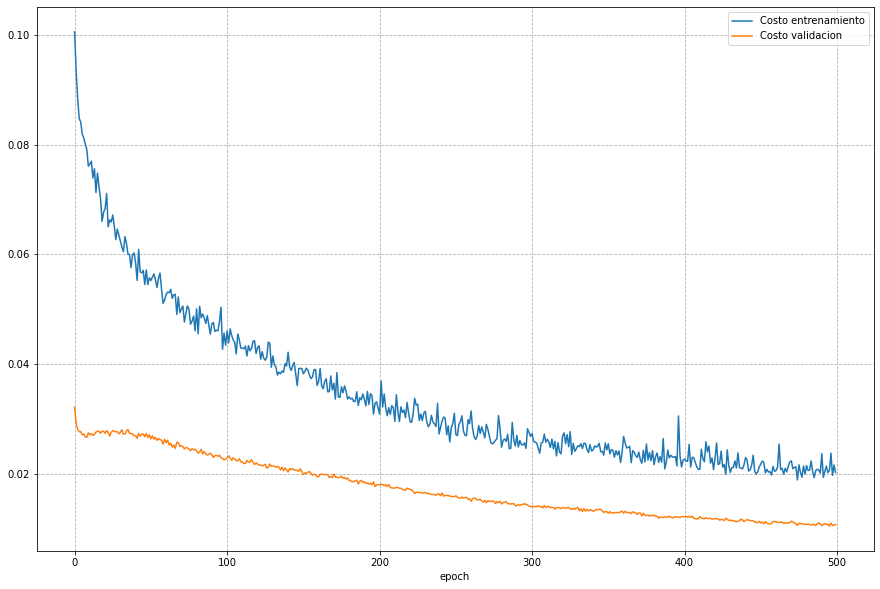

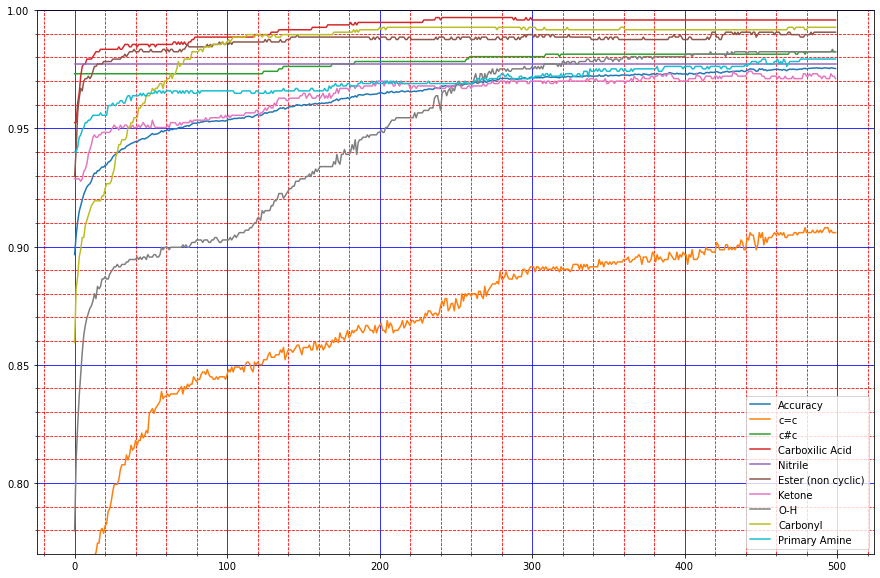

In [95]:
xaxis=torch.arange(0, epochs, 1)

plt.plot(xaxis.numpy(), loss_train, label='Costo entrenamiento')
plt.plot(xaxis.numpy(), loss_val, label='Costo validacion')
plt.xlabel('epoch')
plt.legend()
plt.grid(linestyle = '--')
plt.show()
                                    
plt.plot(xaxis.numpy(), accuracy_list, label='Accuracy')
plt.plot(xaxis.numpy(), accuracy_list_bonds[0], label='c=c')
plt.plot(xaxis.numpy(), accuracy_list_bonds[1], label='c#c')
plt.plot(xaxis.numpy(), accuracy_list_bonds[2], label='Carboxilic Acid')
plt.plot(xaxis.numpy(), accuracy_list_bonds[3], label='Nitrile')
plt.plot(xaxis.numpy(), accuracy_list_bonds[4], label='Ester (non cyclic)')
plt.plot(xaxis.numpy(), accuracy_list_bonds[5], label='Ketone')
plt.plot(xaxis.numpy(), accuracy_list_bonds[6], label='O-H')
plt.plot(xaxis.numpy(), accuracy_list_bonds[7], label='Carbonyl')
plt.plot(xaxis.numpy(), accuracy_list_bonds[8], label='Primary Amine')
plt.rcParams["figure.figsize"] = (15,10)
plt.legend()
#plt.grid(linestyle = '--')
plt.minorticks_on()
plt.grid(b=True, which='major', color='b', linestyle='-')
plt.grid(b=True, which='minor', color='r', linestyle='--')
plt.ylim(0.77,1)
plt.show()

In [96]:
max(accuracy_list)

tensor(0.9756)